In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from analcisprop.constants import *
import analcisprop.utils.variable_changes as vc

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from p_tqdm import p_map

### Initial Conditions

In [3]:
# osculating elements
akm = RL + 500
ecc0 = 0.01
inc0 = 10*deg
om0 = 20*deg
OM0 = 30*deg
M0 = 15*deg

tmax = 365*1/2
dt = 1
tgrid = np.linspace(0.0, tmax, int(1 + tmax/dt), endpoint = True)

# Cartesian Integration

In [4]:
import analcisprop.propagators.cartesian_propagator as crt


Heyoka Taylor integrator:
 C++ datatype            : double
Tolerance               : 2.220446049250313e-16
High accuracy           : false
Compact mode            : true
Taylor order            : 20
Dimension               : 6
Time                    : 0
State                   : [2500, 456, 975, 1265, 345, 2356]


Taylor order:
 476


In [5]:
ic0 = vc.par2ic([akm, ecc0, inc0, OM0, om0, M0], GML)
sol = crt.propagate(tmax, dt, ic0)

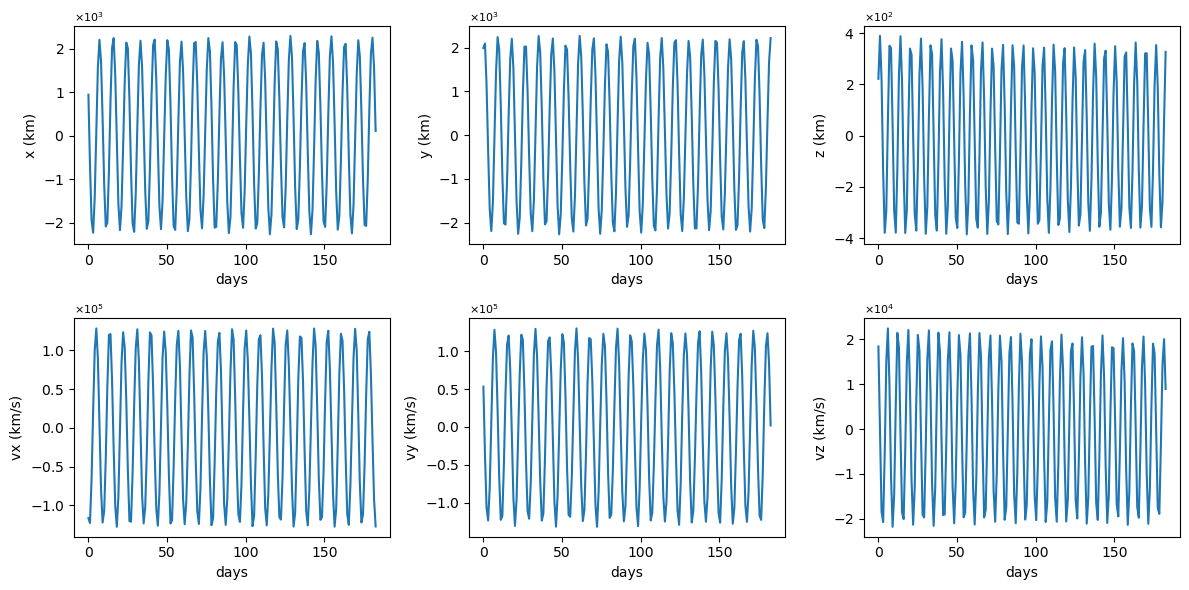

In [6]:
plt.figure(figsize=(12, 6))

cartesian_var_names = ['x (km)', 'y (km)', 'z (km)', 'vx (km/s)', 'vy (km/s)', 'vz (km/s)']

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol[:, i])
    plt.ylabel(cartesian_var_names[i])
    plt.xlabel('days')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

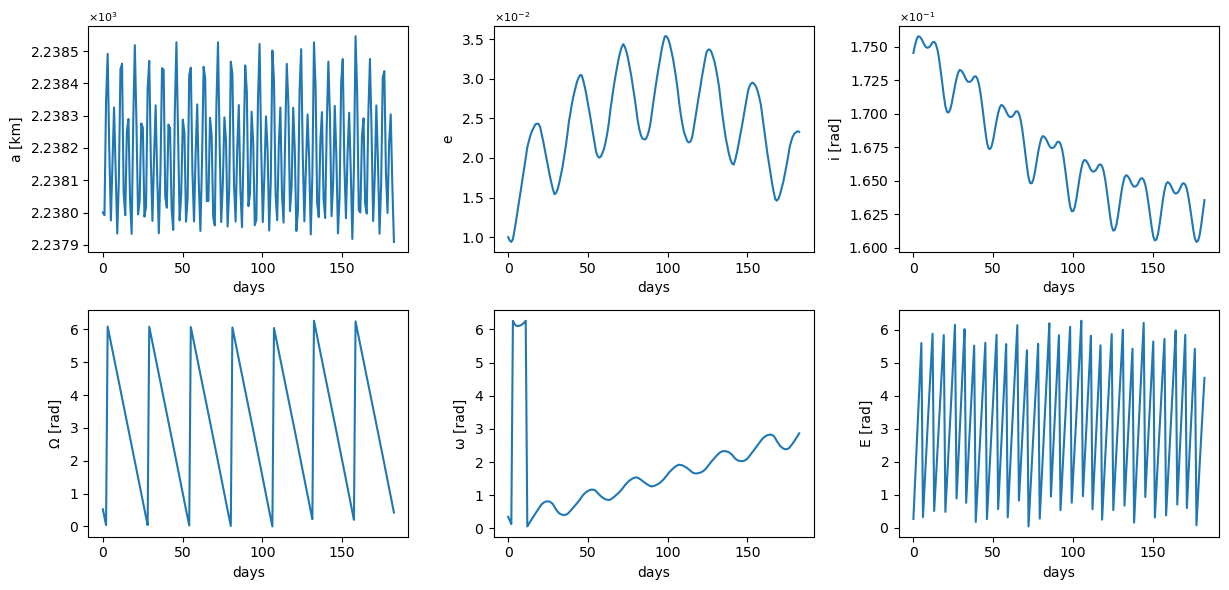

In [7]:
sol_kep = np.array([vc.ic2par(sol[j], GML) for j in range(len(sol))])

kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'E [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i])
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

In [8]:
def cart2mean(j):
    [a, ecc, inc, OM, om, ecc_an] = sol_kep[j]
    t = tgrid[j]
    mean_an = vc.E2M(ecc_an, ecc)
    osc_kep = [a, ecc, inc, OM, om, mean_an]
    mean_kep = vc.osc2mean(osc_kep, t)
    return mean_kep


In [9]:
mean_cart = np.array(p_map(cart2mean, range(len(tgrid))))

  0%|          | 0/183 [00:00<?, ?it/s]

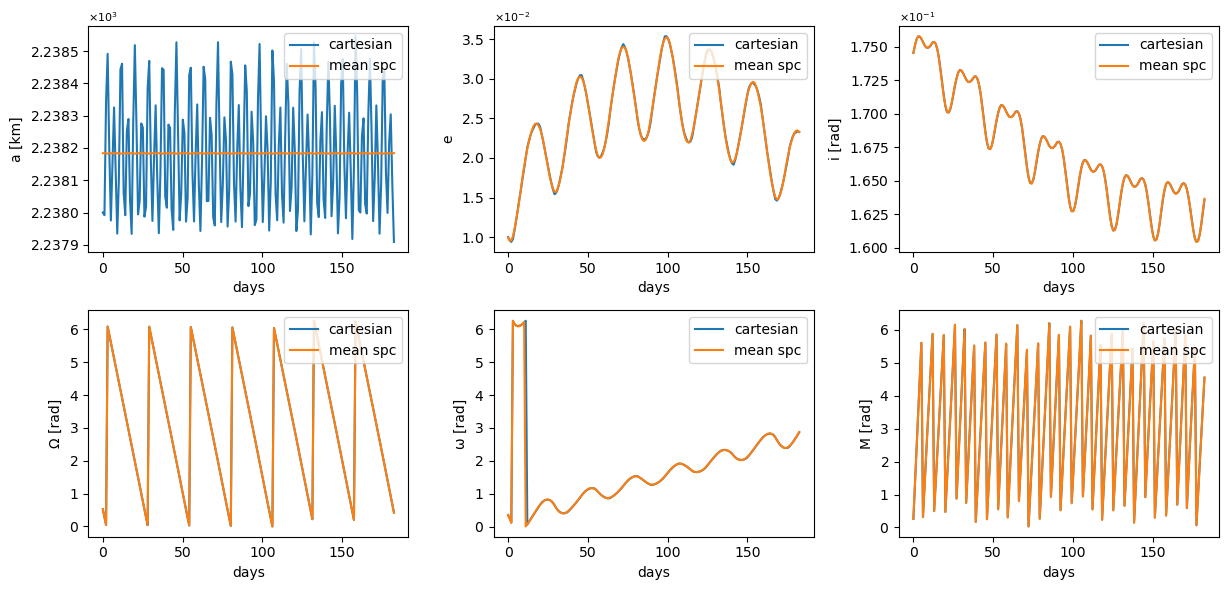

In [10]:
sol_kep = np.array([vc.ic2par(sol[j], GML) for j in range(len(sol))])

kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, mean_cart[:, i], label = 'mean spc')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

In [11]:
orbit_trace = go.Scatter3d(
    x=sol[:, 0],
    y=sol[:, 1],
    z=sol[:, 2],
    mode='lines',
    name='Orbit Trajectory',
    line=dict(color='blue', width=2)
)


# Create a sphere mesh
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
phi, theta = np.meshgrid(phi, theta)

x = RL * np.sin(phi) * np.cos(theta)
y = RL * np.sin(phi) * np.sin(theta)
z = RL * np.cos(phi)

sphere_trace = go.Surface(
    x=x,
    y=y,
    z=z,
    colorscale=[[0, 'grey'], [1, 'grey']],
    opacity=0.5,
    name='Central Body',
    showscale=False
)

layout = go.Layout(
    title='3D Visualization of the Orbit',
    scene=dict(
        xaxis_title='X Position (km)',
        yaxis_title='Y Position (km)',
        zaxis_title='Z Position (km)',
        aspectmode='data'  # Ensures equal scaling on all axes
    ),
    legend=dict(
        x=0,
        y=1
    )
)

fig = go.Figure(data=[orbit_trace, sphere_trace], layout=layout)

# Show the figure
fig.show()


# Secular Integration

In [13]:
import analcisprop.propagators.secular_propagator as sec_int

In [17]:
import analcisprop.propagators.secular_scipy as sec_sp

In [18]:
# find mean initial conditions
[akm_mean, ecc0_mean, inc0_mean, OM0_mean, om0_mean, M0_mean] = vc.osc2mean([akm, ecc0, inc0, OM0, om0, M0], 0.0)

In [22]:
ic0_eq = vc.kep2equinox([akm_mean, ecc0_mean, inc0_mean, OM0_mean, om0_mean, M0_mean])

In [29]:
solver_options = {
    'method': 'RK45',
    't_eval': tgrid,
    'rtol': 1e-8,
    'atol': 1e-8
}
t_span=(0, tmax)

sec_sol_eq = sec_sp.propagate(ic0_eq, t_span, **solver_options)

In [30]:
sol_sec_kep_list = []

# Iterate through each time step (columns of sol_sec_eq.y)
for j in range(sec_sol_eq.y.shape[1]):
    # Get the equinoctial state vector at time step j
    equinoctial_state = sec_sol_eq.y[:, j]

    # Convert the equinoctial state to Keplerian elements
    # Assuming vc.equinox2kep takes only the state vector
    # If it needs GML, add it: vc.equinox2kep(equinoctial_state, GML)
    keplerian_state = vc.equinox2kep(equinoctial_state)

    # Append the result to the list
    sol_sec_kep_list.append(keplerian_state)

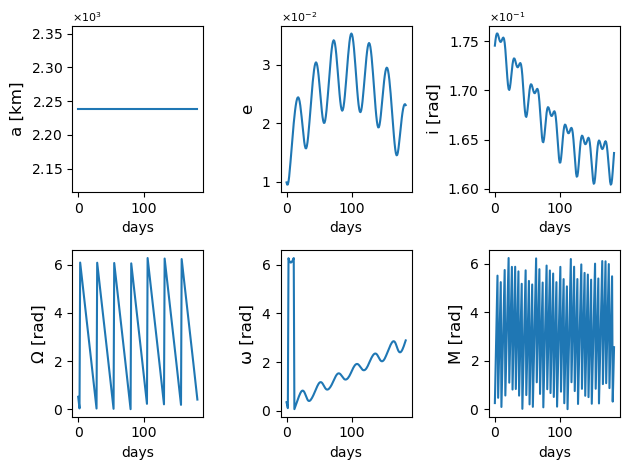

In [34]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]'] # Added 'a' and 'M'

for i in range(6): # Loop through all 6 Keplerian elements
    plt.subplot(2, 3, i+1)
    # Use sol_sec_eq.t for the time axis
    plt.plot(sec_sol_eq.t, np.array(sol_sec_kep_list)[:, i])
    plt.ylabel(kep_var_names[i], fontsize = 12)
    plt.xlabel('days')

    # Optional: Add formatting like in other plots
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))

plt.tight_layout()
plt.show()

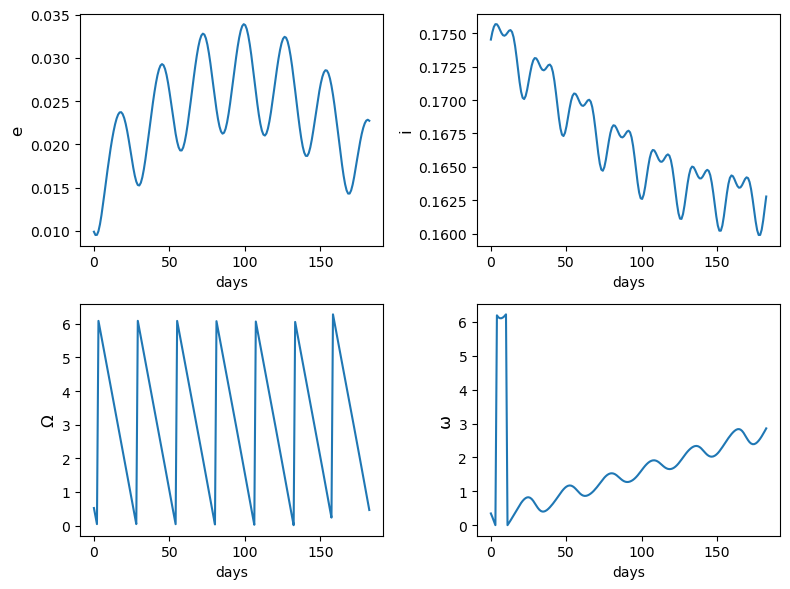

In [15]:
L0, G0, H0, h0, g0 = vc.kep2del([akm_mean, ecc0_mean, inc0_mean, om0_mean, OM0_mean])
l0 = M0_mean
I10, I20, I30, I40 = 0.0, 0.0, 0.0, 0.0
phi10, phi20, phi30, phi40 = 0.0, 0.0, 0.0, 0.0

ic0_del = [L0, G0, H0, l0, g0, h0, 
            I10, I20, I30, I40,
            phi10, phi20, phi30, phi40]

sol_sec_del = sec_int.propagate(tmax, dt, ic0_del, akm) 

sol_sec_kep = []
for j in range(len(sol_sec_del)):
    Lv, Gv, Hv, lv, gv, hv = sol_sec_del[j,:6]
    sol_sec_kep.append(
        list(vc.del2kep([Gv, Hv, gv, hv], Lv)) + [np.mod(lv,2*np.pi)]
    )

sol_sec_kep = np.array(sol_sec_kep)

plt.figure(figsize=(8, 6))

var_names = ['e', 'i', 'Ω', 'ω']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(tgrid, sol_sec_kep[:,i+1])
    plt.ylabel(var_names[i], fontsize = 12)
    plt.xlabel('days')

plt.tight_layout()
plt.show()

# Comparisons

In [35]:
sol_sec_kep_arr = np.array(sol_sec_kep_list)

In [36]:
sol_sec_kep_arr

array([[2.23818446e+03, 9.92336513e-03, 1.74535129e-01, 5.23440042e-01,
        3.48225877e-01, 2.62852822e-01],
       [2.23818446e+03, 9.54152638e-03, 1.75125900e-01, 2.83098555e-01,
        2.35360502e-01, 1.57385987e+00],
       [2.23818446e+03, 9.57657087e-03, 1.75550214e-01, 4.37620634e-02,
        1.07480711e-01, 2.89911687e+00],
       ...,
       [2.23818446e+03, 2.32103462e-02, 1.61776158e-01, 8.95373759e-01,
        2.72709680e+00, 3.23317368e-01],
       [2.23818446e+03, 2.32688284e-02, 1.62716291e-01, 6.50895880e-01,
        2.80805463e+00, 1.44459199e+00],
       [2.23818446e+03, 2.31026954e-02, 1.63636520e-01, 4.08659559e-01,
        2.89150411e+00, 2.56130972e+00]], shape=(183, 6))

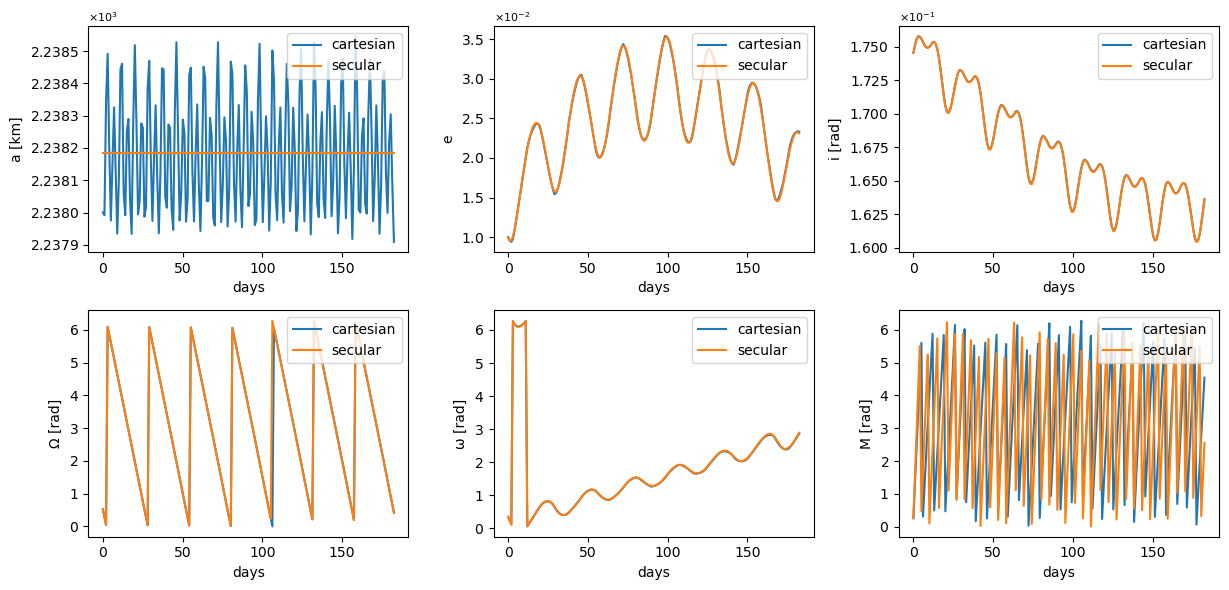

In [37]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, sol_sec_kep_arr[:, i], label = 'secular')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

# SPC correctios

In [54]:
def sec2osc(j):
    [a, ecc, inc, OM, om, mean_an] = sol_sec_kep[j] 
    mean_kep = [a, ecc, inc, OM, om, mean_an]
    t = tgrid[j]
    osc_kep = vc.mean2osc(mean_kep, t)
    return osc_kep


In [55]:
osc_sec = np.array(p_map(sec2osc, range(len(tgrid))))

  0%|          | 0/183 [00:00<?, ?it/s]

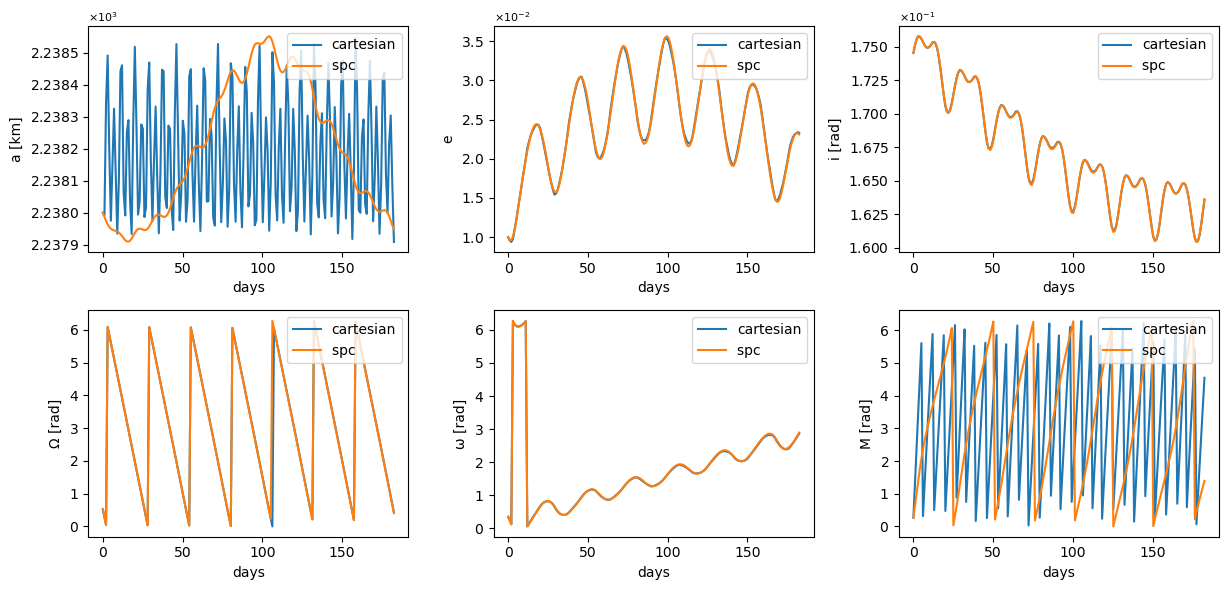

In [56]:
kep_var_names = ['a [km]', 'e', 'i [rad]', 'Ω [rad]', 'ω [rad]', 'M [rad]']

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(tgrid, sol_kep[:, i], label = 'cartesian')
    plt.plot(tgrid, osc_sec[:, i], label = 'spc ')
    plt.ylabel(kep_var_names[i])
    plt.xlabel('days')
    plt.legend(loc = 'upper right')
    # Get the current axis
    ax = plt.gca()
    
    # Create a formatter object
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)  # Enable scientific notation
    formatter.set_powerlimits((-1, 1))  # Use scientific notation for numbers outside this range
    
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_position((0, 1.01))  # Position the offset text above the axis

plt.tight_layout()
plt.show()

# Analytic Solution

In [27]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wlexpr

session = WolframLanguageSession()

In [28]:
session.evaluate(wlexpr(
    'Get[FileNameJoin[{Directory[], "analcisprop","propagators", "NormalForm.m" }]]'
    ));

In [33]:
inc0_mean

np.float64(0.17453513243268484)

In [34]:
efun_str, ifun_str = session.evaluate(
    wlexpr(f'AnalyticEccInc[{akm_mean}, {ecc0_mean}, {inc0_mean}, {OM0_mean}, {om0_mean}, {M0_mean}]')
    )

In [35]:
def string_to_function(expr):
    def func(t):
        return eval(expr, {"np": np, "t": t})
    return func
eanal = string_to_function(efun_str)
ianal = string_to_function(ifun_str)

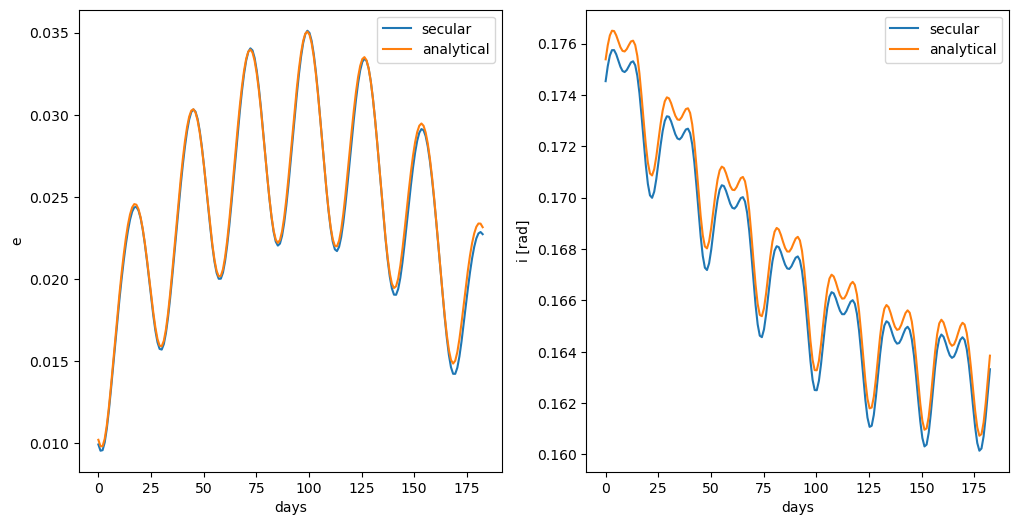

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(tgrid, sol_sec_kep[:, 1], label = 'secular')
plt.plot(tgrid, p_map(eanal, tgrid, disable=True), label = 'analytical')
plt.ylabel('e')
plt.xlabel('days')
plt.legend(loc = 'upper right')

plt.subplot(1, 2, 2)
plt.plot(tgrid, sol_sec_kep[:, 2], label = 'secular')
plt.plot(tgrid, np.array(p_map(ianal, tgrid, disable=True)), label = 'analytical')
plt.ylabel('i [rad]')
plt.xlabel('days')
plt.legend(loc = 'upper right')


In [26]:
session.terminate()

## Time of integration

In [38]:
print('Cartesian')
%timeit crt.propagate(tmax, dt, ic0)

print('\nDelaunay')
%timeit sec_int.propagate(tmax, dt, ic0_del, akm)

print('\nAnalytic')
%timeit p_map(eanal, tgrid, disable=True)

Cartesian
511 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Delaunay
30.7 ms ± 963 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Analytic
121 ms ± 625 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
